### Ubuntu Summit 2023 - Charmed Spark

Check that Spark is running

In [1]:
sc

<SparkContext master=k8s://https://10.114.121.49:16443 appName=PySparkShell>

In [2]:
S3_BUCKET="ubuntu-summit"

#### Read data

In [3]:
df = spark.read.format("csv")\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .load(f"s3a://{S3_BUCKET}/data/data.csv.gz")

23/11/04 07:53:06 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [4]:
df.printSchema()

root
 |-- InvoiceNo: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- InvoiceDate: string (nullable = true)
 |-- UnitPrice: double (nullable = true)
 |-- CustomerID: integer (nullable = true)
 |-- Country: string (nullable = true)



In [5]:
df.show(truncate=True)

+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|InvoiceNo|StockCode|         Description|Quantity|   InvoiceDate|UnitPrice|CustomerID|       Country|
+---------+---------+--------------------+--------+--------------+---------+----------+--------------+
|   536365|   85123A|WHITE HANGING HEA...|       6|12/1/2010 8:26|     2.55|     17850|United Kingdom|
|   536365|    71053| WHITE METAL LANTERN|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84406B|CREAM CUPID HEART...|       8|12/1/2010 8:26|     2.75|     17850|United Kingdom|
|   536365|   84029G|KNITTED UNION FLA...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|   84029E|RED WOOLLY HOTTIE...|       6|12/1/2010 8:26|     3.39|     17850|United Kingdom|
|   536365|    22752|SET 7 BABUSHKA NE...|       2|12/1/2010 8:26|     7.65|     17850|United Kingdom|
|   536365|    21730|GLASS STAR FROSTE...|       6|12/1/2010 8:26|     4.

#### Analyze the data

In [6]:
from pyspark.sql.functions import col

##### Top Products

In [7]:
quantity_by_stock_code = \
    df.groupBy("StockCode").sum("Quantity")

quantity_by_stock_code

DataFrame[StockCode: string, sum(Quantity): bigint]

In [8]:
top_sellers = \
    quantity_by_stock_code\
        .sort(col("sum(Quantity)").desc())\
        .limit(10)\
        .toPandas().set_index("StockCode")

top_sellers

,sum(Quantity)
StockCode,
22197,56450
84077,53847
85099B,47363
85123A,38830
84879,36221
21212,36039
23084,30646
22492,26437
22616,26315


<Axes: xlabel='StockCode'>

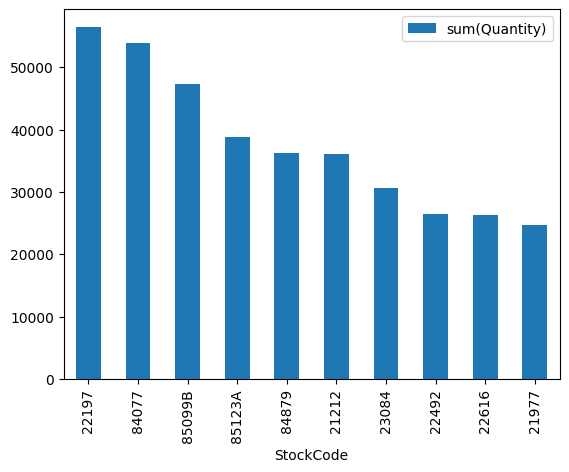

In [9]:
top_sellers.plot(kind="bar")

##### Geographic Distribution 

In [10]:
country_sales = df.groupBy("Country").sum("Quantity").sort(col("sum(Quantity)").desc()).toPandas().set_index("Country")

country_sales

,sum(Quantity)
Country,
United Kingdom,4263829
Netherlands,200128
EIRE,142637
Germany,117448
France,110480
Australia,83653
Sweden,35637
Switzerland,30325
Spain,26824


#### Next steps

What if we were to generate a report, with StockCode and Country, to be sent out to Country managers to help them understand their market and build a strategy around this